In [ ]:
import pandas as pd
import numpy as np
import math
import time

import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.style as style 
import matplotlib.ticker as ticker

%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import GridSearchCV 
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [ ]:
df = pd.read_csv('E:\loans2007-2018.csv',low_memory=False)

In [31]:
df.shape

(2260701, 151)

In [119]:
df.info()
pd.set_option('display.max_columns', None)
result = df.dtypes
print(result)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(112), object(39)
memory usage: 2.5+ GB
id                        object
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object


In [23]:
#Let's explore the data by looking at the number of loans by their loan status.
loans_by_status = df.groupby(df["loan_status"]).id.count().reset_index()
loans_by_status = loans_by_status.sort_values('id', ascending=False)

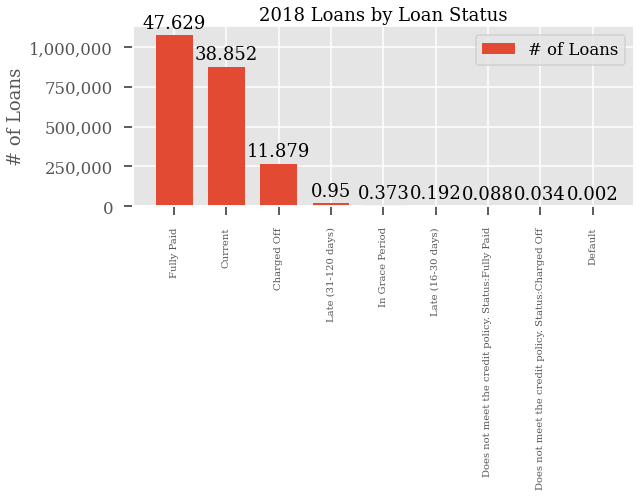

In [37]:
#Let's plot the loans by status and look at their percentage relative to total
from matplotlib import pyplot
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}

pyplot.rc('font', **font)
sns.set_context('talk')

x = np.arange(len(loans_by_status["loan_status"]))  # the label locations
width = 0.70  # the width of the bars

fig, ax = plt.subplots(figsize=(9,7))
rects1 = ax.bar(x, loans_by_status["id"], width, label='# of Loans')

# Add some text for labels, title and custom x-axis tick labels, etc.
import matplotlib.style as style
import matplotlib.ticker as ticker
ax.set_ylabel('# of Loans')
ax.set_title('2018 Loans by Loan Status')
ax.set_xticks(x)
ax.set_xticklabels(loans_by_status["loan_status"], rotation=90, fontsize=10)
ax.legend()

y_labels = ax.get_yticks()
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its count & percent."""
    for rect in rects:
        height = rect.get_height()
        percent = round((height/df.shape[0])*100,3)
        ax.annotate('{}'.format(percent),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
fig.tight_layout()
plt.savefig("E:\loans_by_loan_status.png")
plt.show()

In [51]:
#what are the top recurring professions for Lending Club borrowers?
top_recur_jobs = df.groupby("emp_title").id.count().sort_values(ascending=False).head(100)
top_recur_jobs = pd.DataFrame(top_recur_jobs)

#drop the blank job entries
top_recur_jobs.dropna()

,id
emp_title,
Teacher,38824
Manager,34298
Owner,21977
Registered Nurse,15867
Driver,14753
...,...
Firefighter,1552
Underwriter,1535
Sales Associate,1526


TypeError: savefig() takes 2 positional arguments but 3 were given

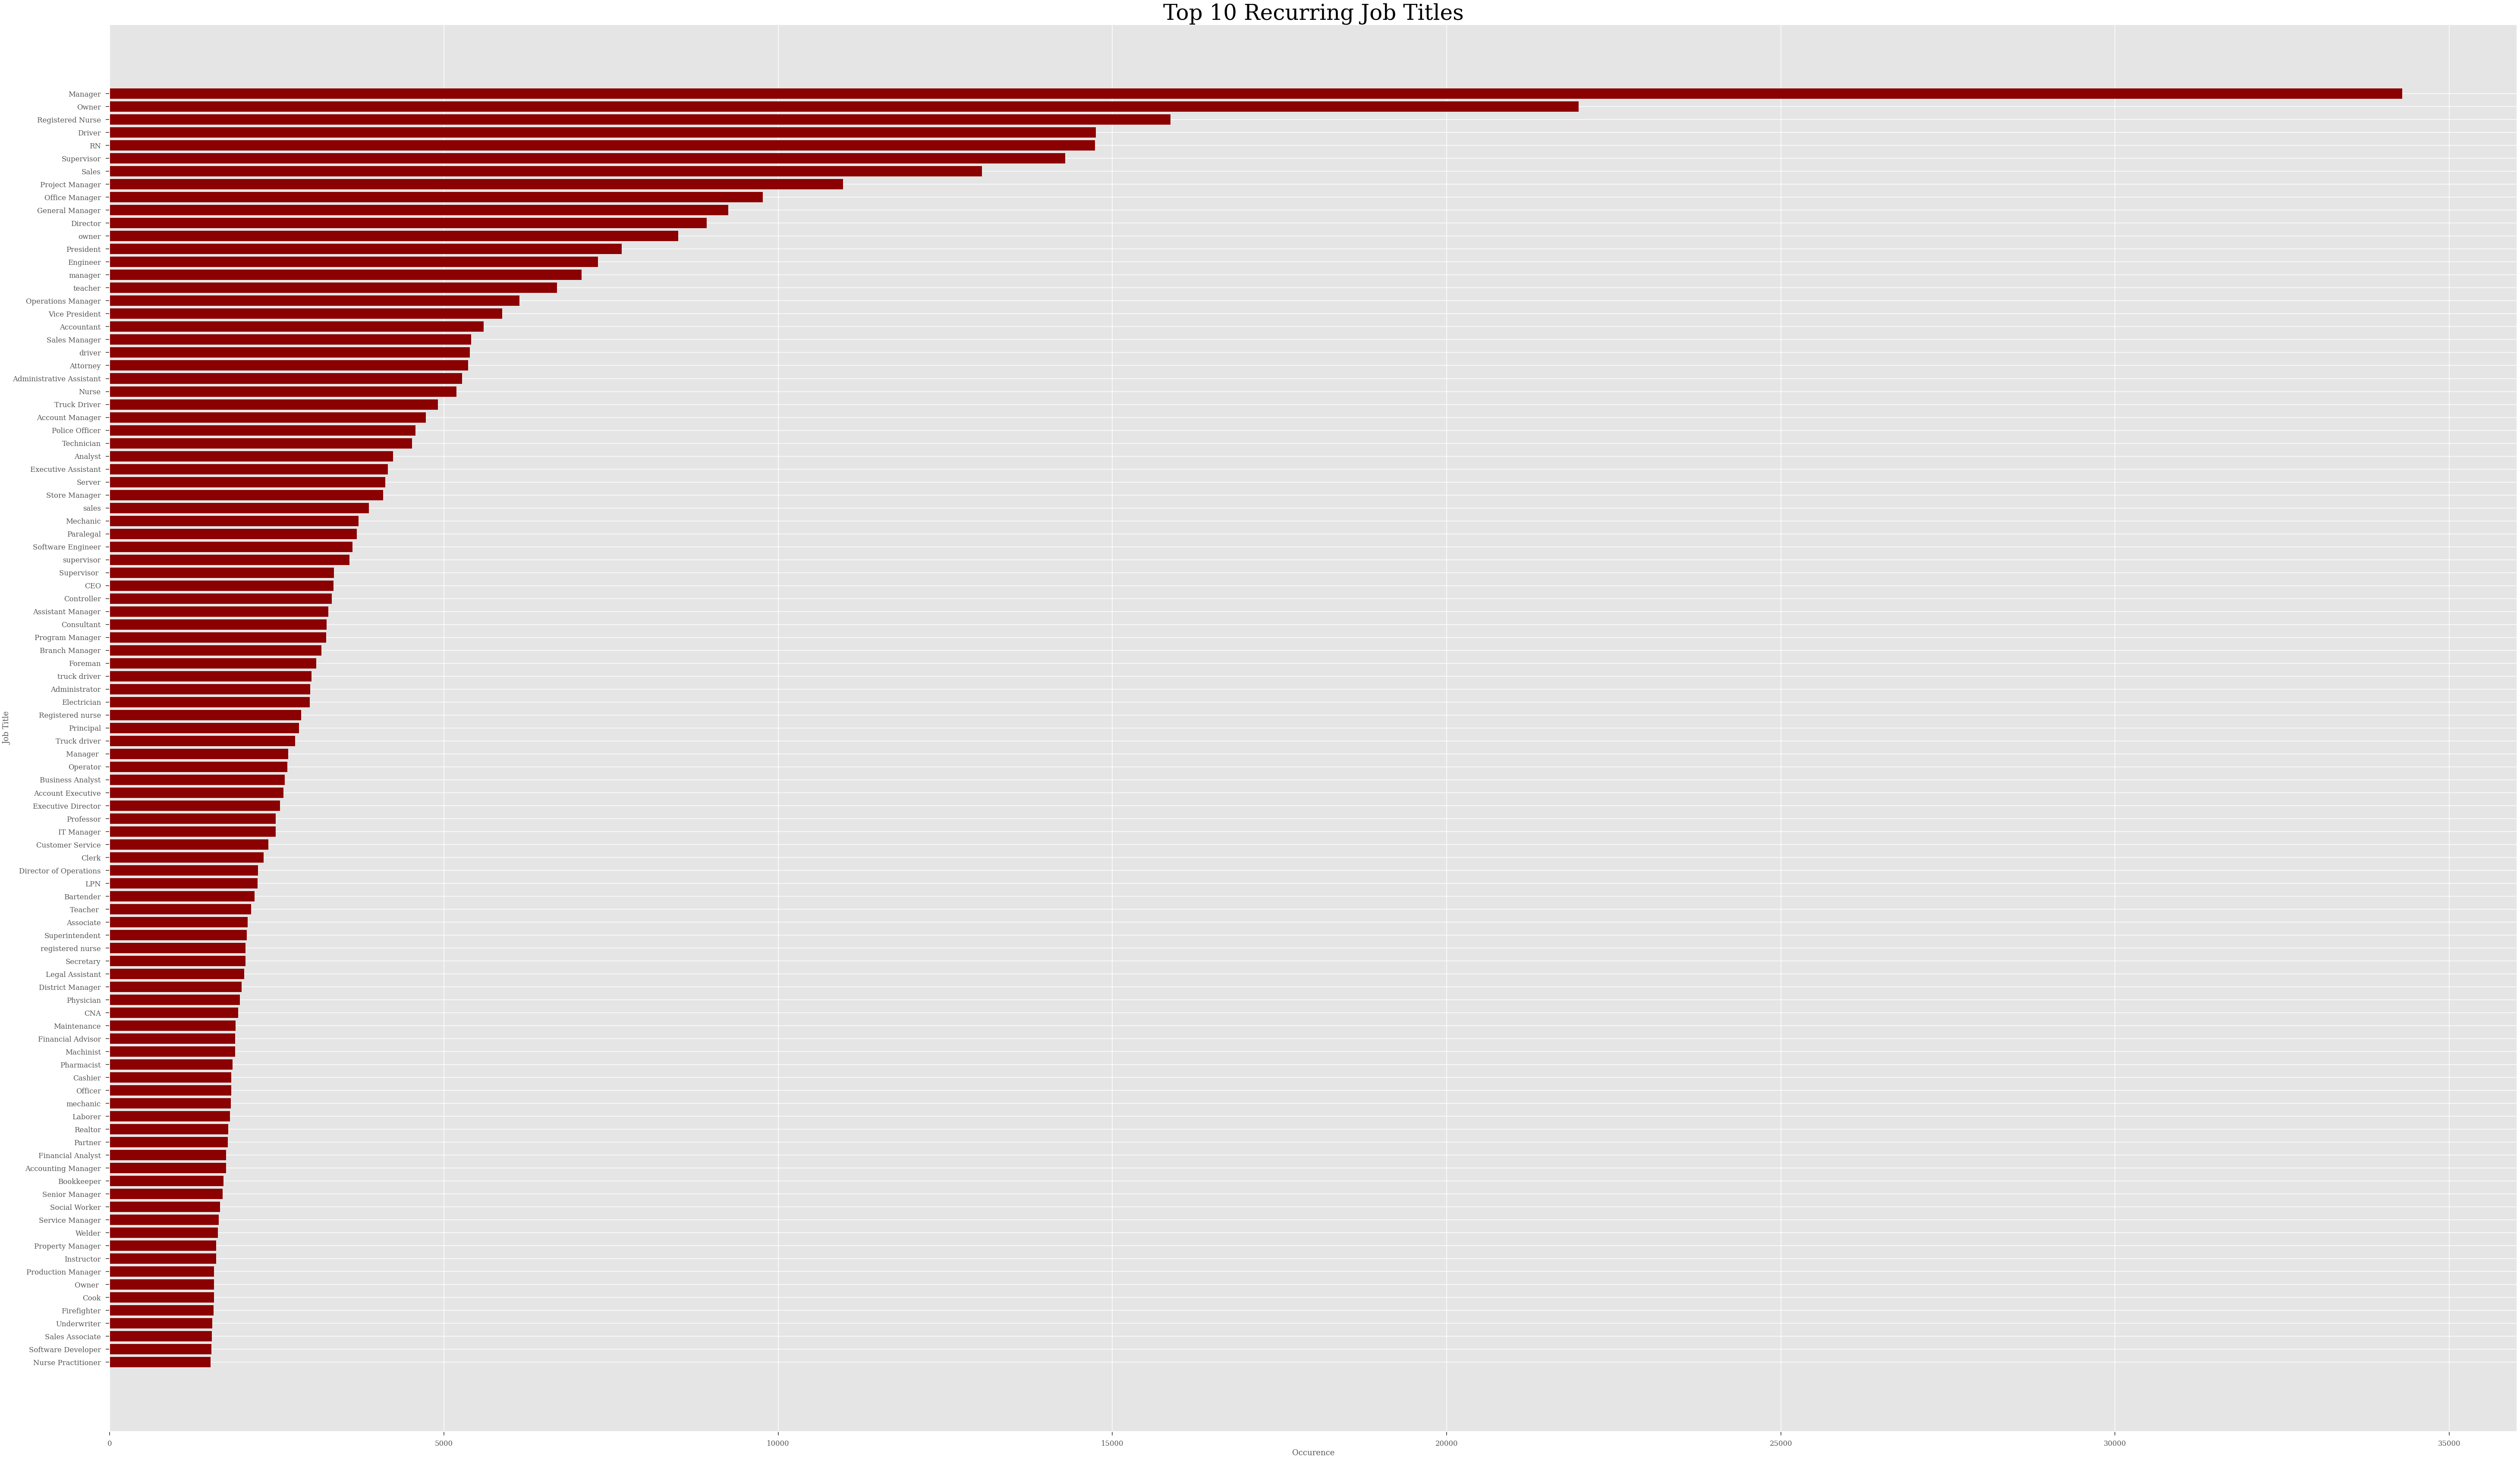

In [48]:
#remove the blank value
emp_data = top_recur_jobs[1:].sort_values(by=['id'])

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 50}

pyplot.rc('font', **font)
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(100,60))
rects1 = ax.barh(emp_data.index, emp_data["id"], color='darkred')
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
plt.ylabel("Job Title")
plt.xlabel("Occurence")
plt.title("Top 10 Recurring Job Titles", fontsize="50")
plt.savefig("E:\toprecurringjobs.png",0)
plt.show()


OSError: [Errno 22] Invalid argument: 'E:\top_purposes.png'

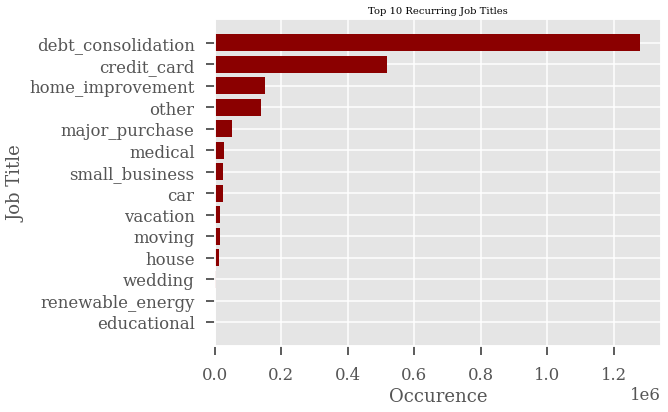

In [49]:
#what are the top recurring professions for Lending Club borrowers?
purpose = df.groupby("purpose").id.count().sort_values(ascending=False)
purpose = pd.DataFrame(purpose)

#remove the blank value
purp_data = purpose.sort_values(by=['id'])

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}

pyplot.rc('font', **font)
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.barh(purp_data.index, purp_data["id"], color='darkred')
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
plt.ylabel("Job Title")
plt.xlabel("Occurence")
plt.title("Top 10 Recurring Job Titles", fontsize="10")
plt.savefig("E:\top_purposes.png")
plt.show()

In [53]:
#let's split up the loans to compare bad loans to good loans

current_loans_mask = ((df["loan_status"]=="Current"))

good_loans_mask = (df["loan_status"]=="Fully Paid")

questionable_loans_mask = ((df["loan_status"]=='Late (31-120 days)') |
                  (df["loan_status"]=='Late (16-30 days)') |
                  (df["loan_status"]=='In Grace Period'))

bad_loans_mask = ((df["loan_status"]=='Default') |
                  (df["loan_status"]=='Charged Off'))

investment_grade = ((df['grade']=='A') 
                      | (df['grade']=='B')
                      | (df['grade']=='C'))

non_investment_grade = ((df['grade']=='D') 
                      | (df['grade']=='E')
                      | (df['grade']=='F')
                      | (df['grade']=='G'))

In [55]:
#how many good vs. bad loans were there overall?
good_loans = df[good_loans_mask | current_loans_mask | questionable_loans_mask].shape[0]
bad_loans = df[bad_loans_mask].shape[0]
total = good_loans+bad_loans
print("Overall Good Loans: ", good_loans, " - ", round(((good_loans/total)*100),2), "%")
print("Overall Bad Loans : ", bad_loans, "  - ", round(((bad_loans/total)*100),2), "%")


Overall Good Loans:  1989320  -  88.1 %
Overall Bad Loans :  268599   -  11.9 %


In [56]:
#Let's remove current loans because they are yet to pay out
good_loans = df[good_loans_mask].shape[0]
bad_loans = df[bad_loans_mask].shape[0]
total = good_loans+bad_loans
print("Good Loans (ex Current): ", good_loans, " - ", round(((good_loans/total)*100),2), "%")
print("Bad Loans (ex Xurrent) : ", bad_loans, "  - ", round(((bad_loans/total)*100),2), "%")


Good Loans (ex Current):  1076751  -  80.04 %
Bad Loans (ex Xurrent) :  268599   -  19.96 %


In [61]:
#Let's look at default rates for investment grade loans (i.e. Grade: A,B,C)
good_loans = df[investment_grade & good_loans_mask].shape[0]
bad_loans = df[investment_grade & bad_loans_mask].shape[0]
total = good_loans+bad_loans
print("Investment Grade Good Loans (ex Current): ", good_loans, " - ", round(((good_loans/total)*100),2), "%")
print("Investment Grade Bad Loans (ex Current) : ", bad_loans, "  - ", round(((bad_loans/total)*100),2), "%")


Investment Grade Good Loans (ex Current):  857098  -  84.9 %
Investment Grade Bad Loans (ex Current) :  152439   -  15.1 %


In [57]:
#Let's look at default rates for non-investment grade loans
good_loans = df[non_investment_grade & good_loans_mask].shape[0]
bad_loans = df[non_investment_grade & bad_loans_mask].shape[0]
total = good_loans+bad_loans
print("Non-Investment Grade Good Loans (ex Current): ", good_loans, " - ", round(((good_loans/total)*100),2), "%")
print("Non-Investment Grade Bad Loans (ex Current) : ", bad_loans, "  - ", round(((bad_loans/total)*100),2), "%")


Non-Investment Grade Good Loans (ex Current):  219653  -  65.41 %
Non-Investment Grade Bad Loans (ex Current) :  116160   -  34.59 %


In [59]:
#Let's look at the defaults by letter grade
overall = df.groupby("grade").id.count()
bads = df[bad_loans_mask].groupby("grade").id.count()
for i, v in enumerate(overall):
    print((bads[i]/overall[i])*100)

3.2806268431298737
7.923358505750071
13.176925573760908
18.823206667817423
26.57126637618974
34.66985645933015
37.47534516765286


In [64]:
df['emp_title'] = df['emp_title'].astype(str)
all_loans_emp = df.copy()
all_loans_emp["emp_title"] = df["emp_title"].apply(lambda x: x.lower())
all_loans_emp = all_loans_emp.groupby("emp_title").id.count().sort_values(ascending=False).head(12)


In [65]:
all_loans_emp[1:]

emp_title
teacher             46125
manager             42822
owner               31740
registered nurse    21407
driver              20786
supervisor          18560
sales               17647
rn                  16672
office manager      13163
project manager     12891
general manager     12111
Name: id, dtype: int64

In [ ]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}

pyplot.rc('font', **font)
sns.set_context('talk')

bad_loans = bad_loans[1:].sort_values(by=['id'])

fig, ax = plt.subplots(figsize=(100,60))
rects1 = ax.barh(bad_loans.index, bad_loans["id"], color='darkred')
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
#plt.barh(top_recur_jobs.index, top_recur_jobs["id"], color='green')
plt.ylabel("Job Title")
plt.xlabel("Occurence")
plt.title("Top 10 Defaulters by Job Titles", fontsize="50")
plt.savefig("E:\top_jobs_by_default.png")
plt.show()

In [ ]:
#excluding current loans because we don't know whether they will pay out and will only add noise to our model
lc_2018 = df[(  (good_loans_mask) | (bad_loans_mask))]
print(lc_2018.dtypes['term'])

In [70]:
lc_2018.shape

(1345350, 151)

In [ ]:
df_copy = lc_2018.copy()
print(df_copy.dtypes['term'])

In [116]:
#Now we need to clean up some columns and do some feature engineering

def feature_engineering(df_local):
    #Let's create our dependent variable
    df_local['bad_loan_flag'] = df_local['loan_status'].apply(lambda x: 1 if (x=='Default') | (x=='Charged Off') else 0)
    
    #strip the literal 'months' from the term 
   
    df_local["term"] = df_local["term"].str.rstrip(' months')
    df_local["term"] = df_local["term"].astype('int32')   

    #FICO range doesn't need to be a float
    df_local["fico_range_high"] = df_local["fico_range_high"].astype('int32')

    #strip the % from the interest rate and square it to amplify the data point
   
    df_local["int_rate"] = df_local["int_rate"].str.rstrip('%') 
    df_local["int_rate"] = df_local["int_rate"].astype('float64')
    df_local["int_rate_sqaured"] = df_local["int_rate"].apply(lambda x: math.pow(x,2))

    #take the log of income and loan amount to dampen their effects
    df_local["annual_inc_log"] = df_local["annual_inc"].apply(lambda x: 1 if (x==0) else math.log(x))
    df_local["loan_amnt_log"] = df_local["loan_amnt"].apply(lambda x: 1 if (x==0) else math.log(x))

    #extract the number of years employed
   
    
    #there are some blanks in here so we need to fill with -1
    df_local["emp_length"] = df_local["emp_length"].str.rstrip('years')
    df_local["emp_length"] = df_local["emp_length"].apply(lambda x: -1 if (x=='') else x)
    df_local["emp_length"] = df_local["emp_length"].str.extract(r'(\d*)')
    df_local["emp_length"] = df_local["emp_length"].astype('int32') 

    #debt to income... if DTI is blank i will assign the national average 33%
    df_local["dti"] = df_local["emp_length"].apply(lambda x: 33 if (x=='') else x)
    df_local["dti"] = df_local["dti"].astype('float64') 
    df_local["dti_squared"] = df_local["dti"].apply(lambda x: math.pow(x,2))

    #cast open accounts as int
    df_local["open_acc"] = df_local["open_acc"].astype('int32')

    #revol_util has a % symbol in it.
    df_local["revol_util"] = df_local["revol_util"].apply(lambda x: 10 if (x=='') else x)
    df_local["revol_util"] = df_local["revol_util"].str.rstrip('%')
    df_local["revol_util"] = df_local["revol_util"].astype('float64') 

    #cast average current balance as int
    df_local["avg_cur_bal"] = df_local["avg_cur_bal"].apply(lambda x: -1 if (x=='') else x)
    df_local["avg_cur_bal"] = df_local["avg_cur_bal"].astype('int32')

    #cast bc_open_to_buy
    df_local["bc_open_to_buy"] = df_local["bc_open_to_buy"].apply(lambda x: -1 if (x=='') else x)
    df_local["bc_open_to_buy"] = df_local["bc_open_to_buy"].astype('int32')
    
    return df_local

In [ ]:
df['int_rate'] = df['int_rate'].astype(str)
#df['term'] = df['term'].astype(str)
df.dropna()

df_copy = feature_engineering(df_copy)


In [76]:
#what are the top recurring professions for Lending Club borrowers?
int_rate = df_copy.groupby("grade").int_rate.mean().sort_values(ascending=False)
int_rate = pd.DataFrame(int_rate)
print(int_rate)

        int_rate
grade           
G      27.725938
F      24.934966
E      21.138302
D      17.721692
C      14.021231
B      10.679136
A       7.113041


In [75]:
df_copy["bad_loan_flag"].value_counts()

0    1076751
1     268599
Name: bad_loan_flag, dtype: int64

In [74]:
df_copy[(df_copy["bad_loan_flag"]==1)].head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,bad_loan_flag
13,66624733,NaN,18000.0,18000.0,18000.0,60,19.48,471.70,E,E2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
25,67849662,NaN,4225.0,4225.0,4225.0,36,14.85,146.16,C,C5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
30,67715283,NaN,16000.0,16000.0,16000.0,36,12.88,538.18,C,C2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
31,68341789,NaN,24250.0,24250.0,24250.0,60,24.24,701.01,F,F3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
33,68415473,NaN,25000.0,25000.0,25000.0,60,13.99,581.58,C,C4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1


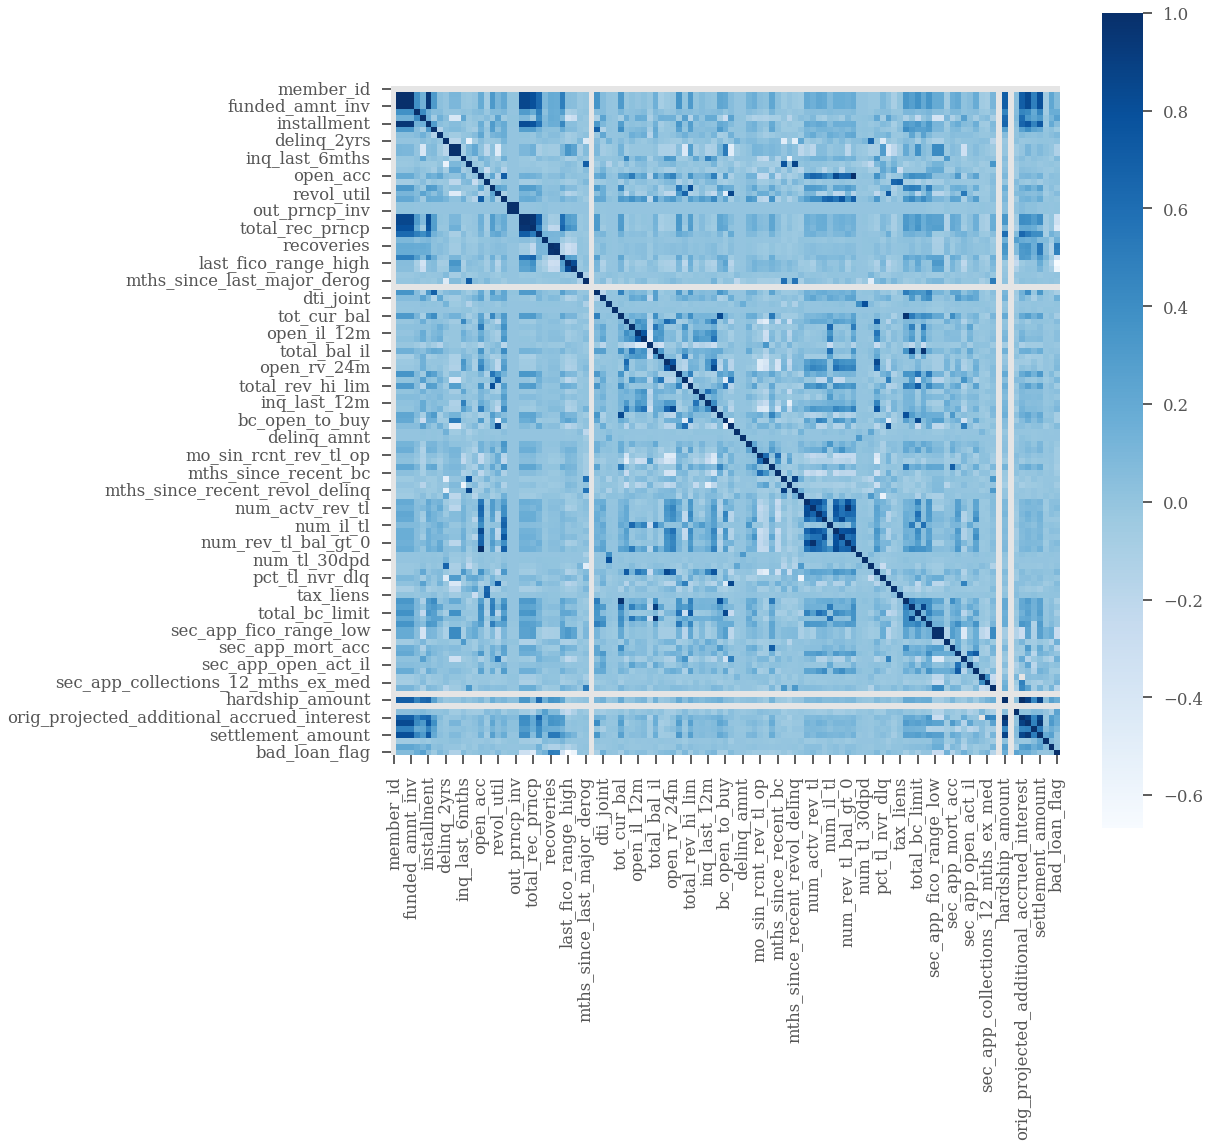

In [83]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_copy.corr(), square=True, cmap="Blues");
plt.savefig(fname="E:\Correlation_Heatmap.png", dpi=150)
plt.show()

In [ ]:
#let's keep 10% as a holdout for later testing
ten_pct=math.ceil((len(df_copy))/10.0)
print(ten_pct)
df.dropna()
df_holdout = feature_engineering(df.sample(n=ten_pct))

In [81]:
#Let's set up our dependent and independent variables
def create_XY(df_local):
    y = df_local["bad_loan_flag"]
    X = df_local[["int_rate", "dti", "annual_inc", "loan_amnt", "fico_range_high", "emp_length"]]

    return X, y

#X = df_copy[["int_rate", "dti", "loan_amnt", "fico_range_high", "emp_length"]]

#X = df_copy[["int_rate", "dti", "loan_amnt", "fico_range_high", "emp_length", "grade", "home_ownership", "verification_status"]]
# X = df_copy[["loan_amnt",
# "home_ownership",
# "annual_inc",
# "verification_status",
# "dti",
# "delinq_2yrs",
# "inq_last_6mths",
# "open_acc",
# "pub_rec",
# "revol_bal",
# #"revol_util",
# "total_acc",
# "collections_12_mths_ex_med",
# "acc_now_delinq",
# "tot_coll_amt",
# "total_rev_hi_lim",
# "acc_open_past_24mths",
# "avg_cur_bal",
# "bc_open_to_buy",
# "chargeoff_within_12_mths",
# "delinq_amnt",
# "mo_sin_old_rev_tl_op",
# "mo_sin_rcnt_rev_tl_op",
# "mo_sin_rcnt_tl",
# "mort_acc",
# "num_accts_ever_120_pd",
# "num_actv_bc_tl",
# "num_actv_rev_tl",
# "num_bc_sats",
# "num_bc_tl",
# "num_il_tl",
# "num_op_rev_tl",
# "num_rev_accts",
# "num_tl_30dpd",
# "num_tl_90g_dpd_24m",
# "num_tl_op_past_12m",
# "pub_rec_bankruptcies",
# "tax_liens",
# "tot_hi_cred_lim",
# "total_bal_ex_mort",
# "total_bc_limit",
# "total_il_high_credit_limit"]]
X,y = create_XY(df_copy)

In [84]:
#significant class imbalance
target_count = y.value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')


Class 0: 1076751
Class 1: 268599
Proportion: 4.01 : 1
Percentage of Majority Class: 80.04


# Utility Functions

In [85]:
#prints accuracy metrics for this model
def print_accuracy_scores(model, X_test, y_test):
    model_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, model_pred)
    print(f'Model Accuracy: {round(accuracy, 4)*100}')
    precision = precision_score(y_test, model_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, model_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, model_pred)
    print('F1 score: %f' % f1)
    auc = roc_auc_score(y_test, model_pred)
    print('ROC AUC: %f' % auc)

In [86]:
#prints accuracy metrics for this model based on predictions
def print_accuracy_scores_on_proba(model_pred, X_test, y_test):
    accuracy = accuracy_score(y_test, model_pred)
    print(f'Model Accuracy: {round(accuracy, 4)*100}')
    precision = precision_score(y_test, model_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, model_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, model_pred)
    print('F1 score: %f' % f1)
    auc = roc_auc_score(y_test, model_pred)
    print('ROC AUC: %f' % auc)

In [87]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [94]:
def plot_roc_curve(models, model_names, X_test, y_test):
    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

    pyplot.rc('font', **font)
    sns.set_context('paper')

    fig, ax = plt.subplots(figsize=(6,6))
    
    for idx, model in enumerate(models):
        probs = model.predict_proba(X_test)
        preds = probs[:,1]
        print(preds)
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)
        ax.plot(fpr, tpr, label = (model_names[idx] + ' AUC = %0.3f' % roc_auc))

    plt.title('ROC Curve')
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    style.available
    style.use('seaborn-poster') #sets the size of the charts
    style.use('ggplot')
    plt.show()

# Model Selection

In [90]:
#pd.get_dummies(X, drop_first=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Random Forest Baseline 

In [115]:
#Let's start with a basic Random Forest classifier
#df['emp_length'] = pd. to_numeric(df['emp_length'])
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

ValueError: could not convert string to float: '10+ years'

In [ ]:
print_accuracy_scores(rf, X_test, y_test)

## Gaussian Naive Bayes